# CSCI 3345, Machine Learning, Spring 2024


In [1]:
pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.3 MB/s eta 0:00:00


In [3]:
pip install tqdm

In [4]:
pip install svgwrite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 893.4 kB/s eta 0:00:00


In [20]:
import numpy as np
import chess
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import svgwrite
import chess.svg
from tqdm.notebook import trange
from IPython.display import SVG, display, clear_output


In [6]:
def generate_moves(piece):
    board = chess.Board(None)  # Create an empty chess board
    moves = []

    for square in chess.SQUARES:
        board.set_piece_at(square, piece)
        moves.append([str(move) for move in board.legal_moves])
        board.remove_piece_at(square)

    return moves

def get_move_matrix():
  moves_count = 0
  move_list = []
  move_q = {}
  move_k = {}

  #generate queen moves
  queen_moves = generate_moves(chess.Piece(chess.QUEEN, chess.WHITE))
  print("Queen moves:")
  for square, moves in zip(chess.SQUARE_NAMES, queen_moves):
      #print(f"{square}: {moves}")
      move_q[square] = moves
      for i in moves:
        moves_count+=1

  # Generate moves for a knight
  knight_moves = generate_moves(chess.Piece(chess.KNIGHT, chess.WHITE))
  print("\nKnight moves:")
  for square, moves in zip(chess.SQUARE_NAMES, knight_moves):
      #print(f"{square}: {moves}")
      move_k[square] = moves
      for i in moves:
        moves_count+=1

  for key1 in move_q:
    for key2 in move_k:
      if key1 == key2:
        for move in move_q[key1]:
          move_list.append(move)
        for i in move_k[key2]:
          move_list.append(i)
  #return np.array(move_list)

  #We must add an extra 44 moves for the promotion (22 for black and 22 for white)
  move_list.append("a7a8q")
  move_list.append("a7b8q")
  move_list.append("b7b8q")
  move_list.append("b7a8q")
  move_list.append("b7c8q")
  move_list.append("c7c8q")
  move_list.append("c7b8q")
  move_list.append("c7d8q")
  move_list.append("d7d8q")
  move_list.append("d7c8q")
  move_list.append("d7e8q")
  move_list.append("e7e8q")
  move_list.append("e7d8q")
  move_list.append("e7f8q")
  move_list.append("f7f8q")
  move_list.append("f7e8q")
  move_list.append("f7g8q")
  move_list.append("g7g8q")
  move_list.append("g7f8q")
  move_list.append("g7h8q")
  move_list.append("h7h8q")
  move_list.append("h7g8q")

  move_list.append("a2a1q")
  move_list.append("a2b1q")
  move_list.append("b2b1q")
  move_list.append("b2a1q")
  move_list.append("b2c1q")
  move_list.append("c2c1q")
  move_list.append("c2b1q")
  move_list.append("c2d1q")
  move_list.append("d2d1q")
  move_list.append("d2c1q")
  move_list.append("d2e1q")
  move_list.append("e2e1q")
  move_list.append("e2d1q")
  move_list.append("e2f1q")
  move_list.append("f2f1q")
  move_list.append("f2e1q")
  move_list.append("f2g1q")
  move_list.append("g2g1q")
  move_list.append("g2f1q")
  move_list.append("g2h1q")
  move_list.append("h2h1q")
  move_list.append("h2g1q")


  print(len(move_list))
  move_list = np.array(move_list)
  np.save('moves.npy', move_list)

get_move_matrix()

Queen moves:

Knight moves:
1836


We make heavy use of the chess python package for running and updating the game/moves. State is the representation of the board, it is a FEN string, which includes every position on the board, whose turn it is, castling rights, etc... The important thing to notice in this game code is that we are never storing the chess.Board object, as we need to save the state after each move during the self play training and having a large object datatype would not be efficient. So we create a new board object and set it to the current position then we use this new object to still be able to use the functionality of the chess package. See example below


In [7]:
def hash_func(n):
  quotient, remainder = divmod(n, 63)
  if remainder >= quotient:
    remainder += 1

  files = ['a','b','c','d','e','f','g','h']
  start = files[quotient % 8] + str(quotient // 8 + 1)
  end = files[remainder % 8 ] + str(remainder // 8 + 1)
  return start + end


In [8]:
moves = np.load('moves.npy')
class ChessInterface:
  def __init__(self):
    self.row_count = 8
    self.column_count = 8
    self.action_size = len(moves)
    self.actions = moves


  def get_initial_state(self):
    return chess.Board().fen()


  def get_next_state(self, state, action):
    board = chess.Board()
    board.set_fen(state)
    move = chess.Move.from_uci(action)
    board.push(move)
    state = board.fen()
    return state



  def get_valid_moves(self, state):
    board = chess.Board()
    board.set_fen(state)
    uci_moves = [move.uci() for move in board.legal_moves]
    return uci_moves

  def get_valid_moves_matrix(self, state):
    moves = self.actions
    valid_moves = self.get_valid_moves(state)
    valid_move_matrix = np.zeros(self.action_size)
    for i, move in enumerate(moves):
      for j in valid_moves:
        if move == j:
          valid_move_matrix[i] = 1
    return valid_move_matrix.astype(np.float32)


  def check_win(self, state, action):
    if action == None:
      return False
    board = chess.Board()
    board.set_fen(state)
    if board.is_checkmate():
      return True
    return False


  def get_value_and_terminated(self, state, action):
    board = chess.Board()
    board.set_fen(state)
    if self.check_win(state, action):
      return 1, True
    if board.outcome() != None:
      return 0, True
    return 0, False

  def get_opponent(self, player):
    return -player

  def get_opponent_value(self, value):
    return -value

  def change_perspective(self, state, player): #problem for later but must be changed
    return state * player


  def get_encoded_state(self, state):
    matrices = []
    pieces = ['p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']
    board = chess.Board(state)

    for piece in pieces:
        matrix = np.zeros((8, 8))
        for i in range(64):
            if str(board.piece_at(i)) == piece:
                matrix[i // 8, i % 8] = 1
        matrices.append(matrix)

    # Add a matrix for all free squares
    free_squares = np.zeros((8, 8))
    for i in range(64):
        if board.piece_at(i) is None:
            free_squares[i // 8, i % 8] = 1
    matrices.append(free_squares)

    return_matrices = np.array(matrices)
    return return_matrices.astype(np.float32)



    # first matrix corresponds to the first indice of the piece_types array above, the second to the second indice and so on...



$\textrm{output_size} = \textrm{input_size}-\textrm{kernel_size}+2\cdot\textrm{padding}+1$

In [9]:
class ResNet(nn.Module):
  def __init__(self, game, num_resBlocks, num_hidden, device):
    super().__init__()

    self.device = device
    self.startBlock = nn.Sequential(
      nn.Conv2d(13, num_hidden, kernel_size = 3, padding = 1),
      nn.BatchNorm2d(num_hidden),
      nn.ReLU()
    )
    self.backBone = nn.ModuleList(
      [ResBlock(num_hidden) for i in range(num_resBlocks)]
    )
    self.policyHead = nn.Sequential(
      nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(32 * game.row_count * game.column_count, game.action_size)
    )
    self.valueHead = nn.Sequential(
      nn.Conv2d(num_hidden, 13, kernel_size=3, padding=1),
      nn.BatchNorm2d(13),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(13 * game.row_count * game.column_count, 1),
      nn.Tanh()
    )
    self.to(device)

  def forward(self, x):
    x = self.startBlock(x)
    for resBlock in self.backBone:
        x = resBlock(x)
    policy = self.policyHead(x)
    value = self.valueHead(x)
    return policy, value

class ResBlock(nn.Module):
  def __init__(self, num_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size = 3, padding = 1)
    self.bn1 = nn.BatchNorm2d(num_hidden)
    self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size = 3, padding = 1)
    self.bn2 = nn.BatchNorm2d(num_hidden)

  def forward(self, x):
    residual = x
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.bn2(self.conv2(x))
    x += residual
    x = F.relu(x)
    return x


In [10]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count = 0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []

        self.visit_count = visit_count
        self.value_sum = 0

    def is_fully_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):
        for action, prob in enumerate(policy):
          if prob > 0:
            move = self.game.actions[action]
            child_state = self.state
            child_state = self.game.get_next_state(child_state, move)

            child = Node(self.game, self.args, child_state, self, move, prob)
            self.children.append(child)


    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)


In [11]:
class MCTSParallel:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, states, spGames):


        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
        )
        policy = torch.softmax(policy, axis=1).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size, size=policy.shape[0])

        for i, spg in enumerate(spGames):
            spg_policy = policy[i]
            valid_moves = self.game.get_valid_moves_matrix(states[i])
            spg_policy *= valid_moves
            spg_policy /= np.sum(spg_policy)

            spg.root = Node(self.game, self.args, states[i], visit_count=1)
            spg.root.expand(spg_policy)

        for search in range(self.args['num_searches']):
            for spg in spGames:
                spg.node = None
                node = spg.root

                while node.is_fully_expanded():
                    node = node.select()

                value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
                value = self.game.get_opponent_value(value)

                if is_terminal:
                    node.backpropagate(value)

                else:
                    spg.node = node

            expandable_spGames = [mappingIdx for mappingIdx in range(len(spGames)) if spGames[mappingIdx].node is not None]

            if len(expandable_spGames) > 0:
                states = np.stack([spGames[mappingIdx].node.state for mappingIdx in expandable_spGames])

                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
                )
                policy = torch.softmax(policy, axis=1).cpu().numpy()
                value = value.cpu().numpy()

            for i, mappingIdx in enumerate(expandable_spGames):
                node = spGames[mappingIdx].node
                spg_policy, spg_value = policy[i], value[i]

                valid_moves = self.game.get_valid_moves_matrix(node.state)
                spg_policy *= valid_moves
                spg_policy /= np.sum(spg_policy)

                node.expand(spg_policy)
                node.backpropagate(spg_value)

In [21]:
class LearningAlg():
  def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTSParallel(game, args, model)

  def SelfPlay(self):
    return_memory = []
    player = 1
    state = self.game.get_initial_state()
    board = chess.Board()
    spGames = [SPG(self.game) for spg in range(self.args['num_parallel_games'])]

    while len(spGames) > 0:
        states = np.stack([spg.state for spg in spGames])

        self.mcts.search(states, spGames)

        for i in range(len(spGames))[::-1]:
                spg = spGames[i]

                action_probs = np.zeros(self.game.action_size)
                for child in spg.root.children:
                    action_probs[np.where(self.game.actions == child.action_taken)] = child.visit_count
                action_probs /= np.sum(action_probs)

                spg.memory.append((spg.root.state, action_probs, player))

                temperature_action_probs = action_probs ** (1 / self.args['temperature'])
                temperature_action_probs = temperature_action_probs / np.sum(temperature_action_probs)
                action = np.random.choice(self.game.action_size, p=temperature_action_probs)
                action = self.game.actions[action]

                spg.state = self.game.get_next_state(spg.state, action)

                value, is_terminal = self.game.get_value_and_terminated(spg.state, action)

                if is_terminal:
                    for hist_state, hist_action_probs, hist_player in spg.memory:
                        hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                        return_memory.append(
                            (self.game.get_encoded_state(hist_state),
                            hist_action_probs,
                            hist_outcome)
                        )
                    del spGames[i]

        player = self.game.get_opponent(player)

    return return_memory




  def train(self, memory):
      random.shuffle(memory)
      for batchIdx in range(0,len(memory), self.args['batch_size']):
          sample = memory[batchIdx:min(len(memory)-1,batchIdx + self.args['batch_size'])]
          state, policy_targets, value_targets = zip(*sample)

          state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

          state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
          policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
          value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

          out_policy, out_value = self.model(state)

          policy_loss = F.cross_entropy(out_policy, policy_targets)
          value_loss = F.mse_loss(out_value, value_targets)

          loss = policy_loss + value_loss

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()



  def learn(self):
      for iteration in trange(self.args['num_iterations']):
          memory = []

          self.model.eval()
          for selfPlay_iterations in trange(self.args['num_selfPlay_iterations'] // self.args['num_parallel_games']):
            memory += self.SelfPlay()

          self.model.train()
          for epoch in trange(self.args['num_epochs']):
            self.train(memory)

          torch.save(self.model.state_dict(), f"model_{iteration}.pt")
          torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")



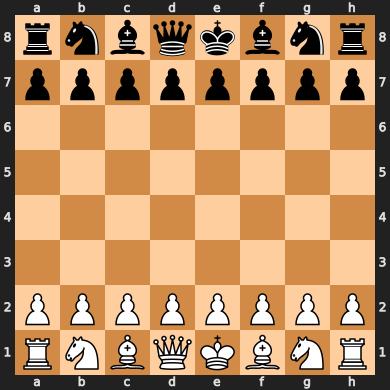

valid_moves ['g1h3', 'g1f3', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']
move:g1h3


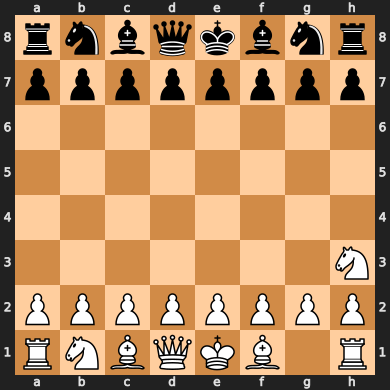

valid_moves ['g8h6', 'g8f6', 'b8c6', 'b8a6', 'h7h6', 'g7g6', 'f7f6', 'e7e6', 'd7d6', 'c7c6', 'b7b6', 'a7a6', 'h7h5', 'g7g5', 'f7f5', 'e7e5', 'd7d5', 'c7c5', 'b7b5', 'a7a5']


KeyboardInterrupt: Interrupted by user

In [ ]:
# Two Human Players Demo
chessGm = ChessInterface()
board = chess.Board()

state = chessGm.get_initial_state()

display(board)
while True:
    valid_moves = chessGm.get_valid_moves(state)
    print("valid_moves", valid_moves)
    action = input(f"move:")

    while action not in valid_moves:
      print("invalid move")
      action = input(f"move:")
    state = chessGm.get_next_state(state, action)
    board.set_fen(state)
    display(board)


    value, is_terminal = chessGm.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break

    player = chessGm.get_opponent(player)

MCTS Demo

1
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1


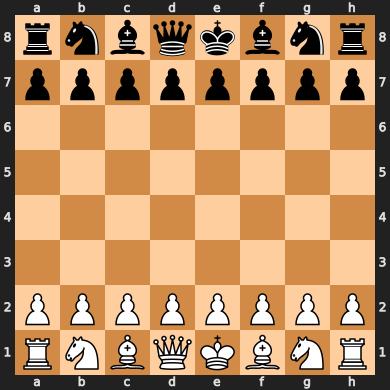

valid_moves ['g1h3', 'g1f3', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']


KeyboardInterrupt: Interrupted by user

In [ ]:
chessGM = ChessInterface()
player = 1
move_list = np.load('moves.npy')
board = chess.Board()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = {
    'C': 2,
    'num_searches': 1000
}

model = ResNet(chessGM, 4, 64, device)
model.eval()

mcts = MCTS(chessGM, args, model)

state = chessGM.get_initial_state()


while True:
    print(player)
    print(state)
    display(board)

    if player == 1:
        valid_moves = chessGM.get_valid_moves(state)
        print("valid_moves", valid_moves)
        action = input(f"{player}:")

        if action not in valid_moves:
            print("action not valid")
            continue

    else:
        mcts_probs = mcts.search(state)
        action = move_list[np.argmax(mcts_probs)]

    state = chessGM.get_next_state(state, action)
    board.set_fen(state)

    value, is_terminal = chessGM.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break

    player = chessGM.get_opponent(player)

In [ ]:
chessGM = ChessInterface()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(chessGM, 4, 16, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
'''
args = {
    'C': 2,
    'num_searches': 100,
    'num_iterations': 5,
    'num_selfPlay_iterations': 2,
    'num_parallel_games' : 2,
    'num_epochs': 10,
    'batch_size': 128,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.002
}'''
args = {
    'C': 2,
    'num_searches': 75,
    'num_iterations': 4,
    'num_selfPlay_iterations': 2,
    'num_parallel_games' : 2,
    'num_epochs': 2,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.002
}

learner = LearningAlg(model, optimizer, chessGM, args)
learner.learn()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
def initialize_chess_AI():
    # Initialize the chess interface
    chessGM = ChessInterface()

    # Check for available device (CPU/GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model
    model = ResNet(chessGM, 4, 16, device)

    # Load the trained model weights
    model.load_state_dict(torch.load("model_4.pt"))
    model.eval()  # Set the model to evaluation mode

    return chessGM, model

def play_chess_with_AI():
    chessGM, model = initialize_chess_AI()
    board = chess.Board()  # Create a new chess board

    while not board.is_game_over():
        # Print the current board
        print(board)

        if board.turn == chess.WHITE:
            # Human player's turn
            human_move = input("Enter your move (in UCI format, e.g., 'e2e4'): ")
            if human_move.lower() == "exit":
                break
            if human_move in [move.uci() for move in board.legal_moves]:
                board.push_uci(human_move)
            else:
                print("Invalid move. Try again.")

        else:
            # AI player's turn
            print(board.fen())
            encoded_state = chessGM.get_encoded_state(board.fen())
            state_tensor = torch.tensor(encoded_state, dtype=torch.float32).unsqueeze(0).to(model.device)
            policy, _ = model(state_tensor)
            legal_moves = [move.uci() for move in board.legal_moves]
            print("Policy shape:", policy.shape)

            legal_policy = [policy[0, chess.Move.from_uci(move).from_square].detach().numpy() if move in legal_moves else float('-inf') for move in chessGM.actions]

            best_move_idx = np.argmax(legal_policy)
            best_move = chessGM.actions[best_move_idx]
            board.push_uci(best_move)



    # Print the final result of the game
    print("Game Over")
    if board.is_checkmate():
        print("Checkmate!")
        print("Winner:", "White" if board.turn == chess.BLACK else "Black")
    elif board.is_stalemate():
        print("Stalemate! It's a draw.")
    elif board.is_insufficient_material():
        print("Insufficient material. It's a draw.")
    elif board.is_seventyfive_moves():
        print("Seventy-five moves rule. It's a draw.")
    elif board.is_fivefold_repetition():
        print("Fivefold repetition. It's a draw.")
    else:
        print("Unknown result.")

# Start the game
play_chess_with_AI()


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


KeyboardInterrupt: Interrupted by user

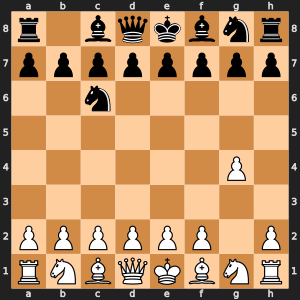

Valid moves: ['g1h3', 'g1f3', 'f1h3', 'f1g2', 'b1c3', 'b1a3', 'g4g5', 'h2h3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']


KeyboardInterrupt: Interrupted by user

In [19]:
chessGM, model = initialize_chess_AI()
board = chess.Board()  # Create a new chess board

# Define the width and height of the SVG board
board_size = 300  # Adjust this value to change the size of the board

# Display the initial board as SVG with the specified size
display(SVG(chess.svg.board(board=board, size=board_size)))

# Initialize the game state
state = chessGM.get_initial_state()

while not board.is_game_over():
    # Human player's turn
    if board.turn == chess.WHITE:
        valid_moves = chessGM.get_valid_moves(state)
        print("Valid moves:", valid_moves)
        action = input("Enter Move: ")

        # Validate the move
        while action not in valid_moves:
            print("Invalid move. Try again.")
            action = input("Enter Move: ")

        # Update the board and state
        state = chessGM.get_next_state(state, action)
        board.set_fen(state)
        clear_output(wait=True)
        display(SVG(chess.svg.board(board=board, size=board_size)))

    else:
        # AI player's turn
        encoded_state = chessGM.get_encoded_state(state)
        state_tensor = torch.tensor(encoded_state, dtype=torch.float32).unsqueeze(0).to(model.device)
        policy, _ = model(state_tensor)
        legal_moves = [move.uci() for move in board.legal_moves]

        legal_policy = [policy[0, chess.Move.from_uci(move).from_square].detach().numpy() if move in legal_moves else float('-inf') for move in chessGM.actions]
        best_move_idx = np.argmax(legal_policy)
        best_move = chessGM.actions[best_move_idx]

        # Update the board and state
        state = chessGM.get_next_state(state, best_move)
        board.set_fen(state)
        clear_output(wait=True)
        display(SVG(chess.svg.board(board=board, size=board_size)))

# Print the final result of the game
print("Game Over")
if board.is_checkmate():
    print("Checkmate!")
    print("Winner:", "White" if board.turn == chess.BLACK else "Black")
elif board.is_stalemate():
    print("Stalemate! It's a draw.")
elif board.is_insufficient_material():
    print("Insufficient material. It's a draw.")
elif board.is_seventyfive_moves():
    print("Seventy-five moves rule. It's a draw.")
elif board.is_fivefold_repetition():
    print("Fivefold repetition. It's a draw.")
else:
    print("Unknown result.")
